# **Assignment 3 - RNN - Time-Series Data**

# **Name: Srilaya Valmeekam**

# **Date: 11-04-2023**

**A temperature-forecasting example- Data Upload from mazon Web Services (AWS) /keras**

In [1]:
!pip install tensorflow==2.12

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-06 01:00:20--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.124.144, 52.217.193.248, 52.216.54.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.124.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  38.7MB/s    in 0.3s    

2023-11-06 01:00:20 (38.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Analysis of the data of the Jena weather dataset - 420451 rows and 15 Features**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**After analyzing the data, certain values are stored in the temperature and raw_data arrays for later processing or analysis. The comma-separated values are converted into floating-point numbers.**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plot for the temperature timeseries**

Text(0, 0.5, 'Temperature')

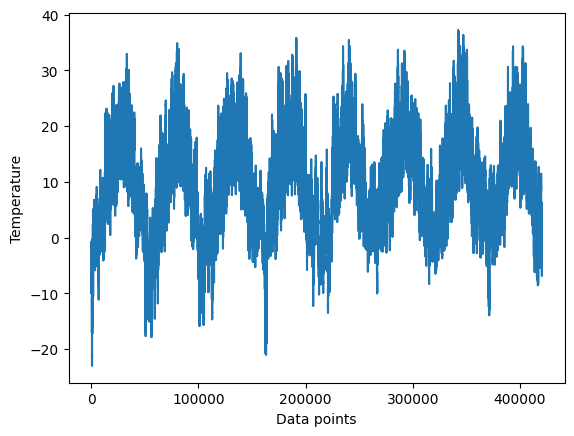

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the temperature timeseries for first ten days: Given that 144 data points are collected in a single day, 10 days will result in 1440 data points**

Text(0, 0.5, 'Temperature')

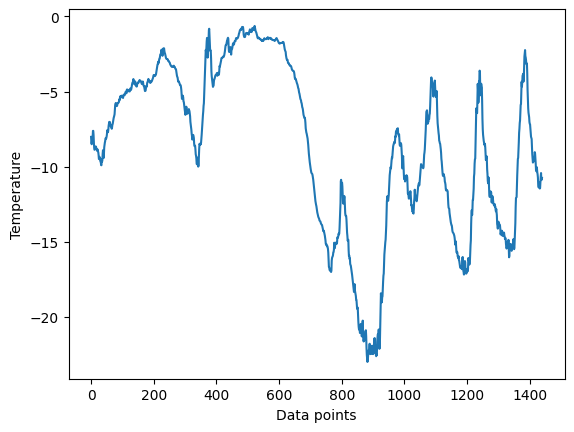

In [6]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Calculating the number of samples we'll use for each data split- 50% for Train, 25%- validation**

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data: Vectorization is not required because the data is already in a numerical representation. Still, it is advised to normalize all variables because the data scales vary amongst them, with temperature ranging from -20 to +30 and pressure measured in millibars.**

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Generating training, validation, and testing datasets—this is necessary due to the large degree of redundancy in the dataset's samples. Therefore, it would be inefficient to explicitly allocate RAM for every sample. Rather, the samples will be produced dynamically**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Generating the output of one of this datasets**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **A common-sense, non-machine-learning baseline**

**Calculating the common-sense baseline MAE: The "evaluate_naive_method" defined function offers a starting point for assessing the effectiveness of a basic forecasting technique that uses the final value in the input sequence in order to predict the value that will come after it.**

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Common-sense baseline approach is to predict that the temperature 24 hours ahead will be identical to the current temperature. By using this straightforward baseline, the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

### **A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [15]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 83s 100ms/step - loss: 13.3162 - mae: 2.8198 - val_loss: 10.4133 - val_mae: 2.5516
Epoch 2/10
819/819 [==============================] - 60s 73ms/step - loss: 9.4125 - mae: 2.4091 - val_loss: 12.1803 - val_mae: 2.7637
Epoch 3/10
819/819 [==============================] - 65s 79ms/step - loss: 8.7531 - mae: 2.3272 - val_loss: 11.4916 - val_mae: 2.6882
Epoch 4/10
819/819 [==============================] - 60s 73ms/step - loss: 8.2897 - mae: 2.2655 - val_loss: 11.1733 - val_mae: 2.6665
Epoch 5/10
819/819 [==============================] - 58s 70ms/step - loss: 7.9555 - mae: 2.2220 - val_loss: 12.5413 - val_mae: 2.8176
Epoch 6/10
819/819 [==============================] - 58s 70ms/step - loss: 7.7060 - mae: 2.1898 - val_loss: 11.2247 - val_mae: 2.6574
Epoch 7/10
819/819 [==============================] - 61s 74ms/step - loss: 7.4670 - mae: 2.1573 - val_loss: 11.3788 - val_mae: 2.6891
Epoch 8/10
819/819 [==============================] -

In [17]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 19s 46ms/step - loss: 11.2821 - mae: 2.6348
Test MAE: 2.63


**Plotting results**

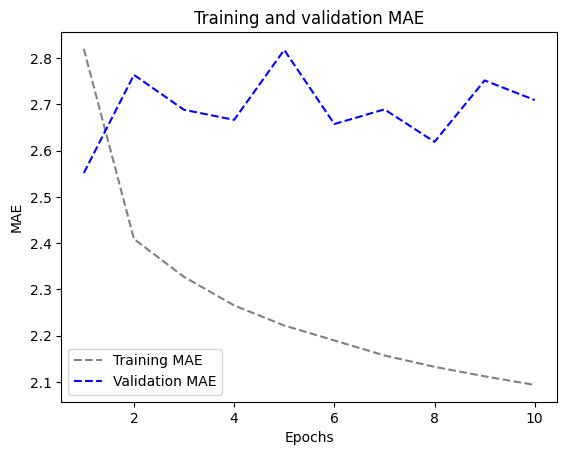

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **Let's try a 1D convolutional model**

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 106s 127ms/step - loss: 22.6687 - mae: 3.7273 - val_loss: 16.1362 - val_mae: 3.1515
Epoch 2/10
819/819 [==============================] - 101s 123ms/step - loss: 15.6578 - mae: 3.1550 - val_loss: 20.4506 - val_mae: 3.5852
Epoch 3/10
819/819 [==============================] - 103s 125ms/step - loss: 14.5508 - mae: 3.0365 - val_loss: 14.7933 - val_mae: 3.0249
Epoch 4/10
819/819 [==============================] - 101s 123ms/step - loss: 13.6277 - mae: 2.9369 - val_loss: 14.7416 - val_mae: 3.0163
Epoch 5/10
819/819 [==============================] - 118s 144ms/step - loss: 12.8772 - mae: 2.8530 - val_loss: 14.3250 - val_mae: 2.9824
Epoch 6/10
819/819 [==============================] - 98s 119ms/step - loss: 12.2913 - mae: 2.7838 - val_loss: 14.3110 - val_mae: 2.9701
Epoch 7/10
819/819 [==============================] - 102s 124ms/step - loss: 11.8660 - mae: 2.7345 - val_loss: 15.1881 - val_mae: 3.0574
Epoch 8/10
819/819 [===============

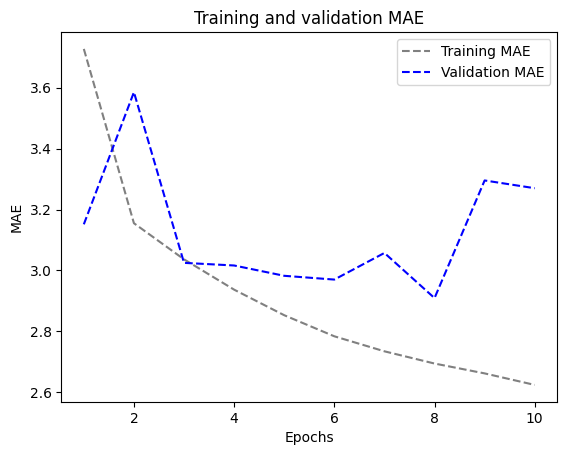

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Convolutional data appear to perform worse than dense models or common sense. It might be due to
- The translation invariance assumption does not hold true for weather data.
- The sequence in which the data is presented is critical. When it comes to forecasting the temperature for the next day, recent historical data is noticeably more useful than data collected several days before. Unfortunately, this important order of time cannot be captured well by a 1D convolutional neural network.





## **A Simple RNN**

### **1.An RNN layer that can process sequences of any length**

In [21]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 91s 106ms/step - loss: 138.9649 - mae: 9.6837 - val_loss: 143.8331 - val_mae: 9.8847
Epoch 2/10
819/819 [==============================] - 104s 126ms/step - loss: 136.2694 - mae: 9.5498 - val_loss: 143.7026 - val_mae: 9.8704
Epoch 3/10
819/819 [==============================] - 86s 104ms/step - loss: 136.1956 - mae: 9.5438 - val_loss: 143.5681 - val_mae: 9.8518
Epoch 4/10
819/819 [==============================] - 102s 124ms/step - loss: 136.1431 - mae: 9.5360 - val_loss: 143.5588 - val_mae: 9.8526
Epoch 5/10
819/819 [==============================] - 82s 100ms/step - loss: 136.1090 - mae: 9.5325 - val_loss: 143.5785 - val_mae: 9.8558
Epoch 6/10
819/819 [==============================] - 105s 128ms/step - loss: 136.1025 - mae: 9.5313 - val_loss: 143.5288 - val_mae: 9.8496
Epoch 7/10
819/819 [==============================] - 87s 106ms/step - loss: 136.0968 - mae: 9.5303 - val_loss: 143.5249 - val_mae: 9.8490
Epoch 8/10
819/819 [====

### **2.Simple RNN - Stacking RNN layers**

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 167s 200ms/step - loss: 137.0585 - mae: 9.5780 - val_loss: 143.4664 - val_mae: 9.8416
Epoch 2/10
819/819 [==============================] - 164s 200ms/step - loss: 135.9897 - mae: 9.5168 - val_loss: 143.4521 - val_mae: 9.8420
Epoch 3/10
819/819 [==============================] - 167s 203ms/step - loss: 135.9221 - mae: 9.5082 - val_loss: 143.4589 - val_mae: 9.8405
Epoch 4/10
819/819 [==============================] - 165s 201ms/step - loss: 135.8949 - mae: 9.5043 - val_loss: 143.5005 - val_mae: 9.8443
Epoch 5/10
819/819 [==============================] - 165s 202ms/step - loss: 135.8713 - mae: 9.5009 - val_loss: 143.4420 - val_mae: 9.8380
Epoch 6/10
819/819 [==============================] - 165s 201ms/step - loss: 135.8620 - mae: 9.4989 - val_loss: 143.4417 - val_mae: 9.8385
Epoch 7/10
819/819 [==============================] - 153s 186ms/step - loss: 135.8529 - mae: 9.4976 - val_loss: 143.4048 - val_mae: 9.8316
Epoch 8/10
819/819 [

## **A Simple GRU (Gated Recurrent Unit)**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 148s 178ms/step - loss: 34.3805 - mae: 4.2285 - val_loss: 10.9714 - val_mae: 2.5094
Epoch 2/10
819/819 [==============================] - 145s 176ms/step - loss: 10.2106 - mae: 2.4969 - val_loss: 9.1846 - val_mae: 2.3400
Epoch 3/10
819/819 [==============================] - 145s 177ms/step - loss: 9.4626 - mae: 2.4053 - val_loss: 9.3362 - val_mae: 2.3597
Epoch 4/10
819/819 [==============================] - 131s 159ms/step - loss: 9.1898 - mae: 2.3682 - val_loss: 9.0648 - val_mae: 2.3344
Epoch 5/10
819/819 [==============================] - 146s 178ms/step - loss: 8.9660 - mae: 2.3391 - val_loss: 9.2435 - val_mae: 2.3603
Epoch 6/10
819/819 [==============================] - 130s 159ms/step - loss: 8.7832 - mae: 2.3158 - val_loss: 9.0773 - val_mae: 2.3549
Epoch 7/10
819/819 [==============================] - 145s 177ms/step - loss: 8.6299 - mae: 2.2979 - val_loss: 9.1471 - val_mae: 2.3577
Epoch 8/10
819/819 [=========================

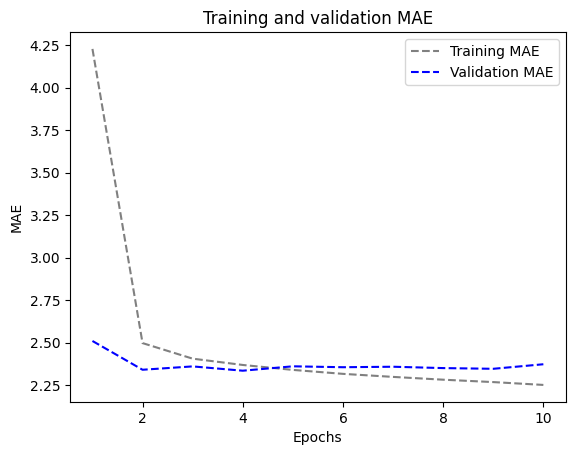

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **LSTM(Long Short-Term Memory )**

### **1.LSTM-Simple**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 145s 173ms/step - loss: 45.6520 - mae: 4.9052 - val_loss: 12.7656 - val_mae: 2.7055
Epoch 2/10
819/819 [==============================] - 129s 158ms/step - loss: 11.0100 - mae: 2.5592 - val_loss: 9.4936 - val_mae: 2.3977
Epoch 3/10
819/819 [==============================] - 144s 176ms/step - loss: 9.2868 - mae: 2.3744 - val_loss: 9.6466 - val_mae: 2.4100
Epoch 4/10
819/819 [==============================] - 144s 176ms/step - loss: 8.6704 - mae: 2.3015 - val_loss: 9.6789 - val_mae: 2.4071
Epoch 5/10
819/819 [==============================] - 145s 176ms/step - loss: 8.3902 - mae: 2.2684 - val_loss: 9.8376 - val_mae: 2.4267
Epoch 6/10
819/819 [==============================] - 132s 161ms/step - loss: 8.1771 - mae: 2.2382 - val_loss: 9.8351 - val_mae: 2.4213
Epoch 7/10
819/819 [==============================] - 131s 159ms/step - loss: 8.0191 - mae: 2.2162 - val_loss: 10.0633 - val_mae: 2.4589
Epoch 8/10
819/819 [========================

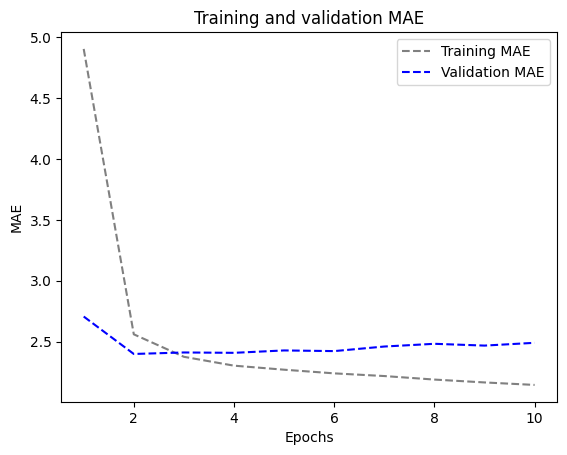

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **2.LSTM - dropout Regularization**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 221s 264ms/step - loss: 43.8576 - mae: 4.9280 - val_loss: 12.8559 - val_mae: 2.7296
Epoch 2/10
819/819 [==============================] - 205s 249ms/step - loss: 19.8428 - mae: 3.4203 - val_loss: 10.1691 - val_mae: 2.4818
Epoch 3/10
819/819 [==============================] - 211s 257ms/step - loss: 18.1878 - mae: 3.2780 - val_loss: 9.5923 - val_mae: 2.4151
Epoch 4/10
819/819 [==============================] - 212s 259ms/step - loss: 17.5050 - mae: 3.2176 - val_loss: 9.3667 - val_mae: 2.3896
Epoch 5/10
819/819 [==============================] - 201s 245ms/step - loss: 16.7412 - mae: 3.1489 - val_loss: 9.3848 - val_mae: 2.3974
Epoch 6/10
819/819 [==============================] - 203s 247ms/step - loss: 16.3637 - mae: 3.1123 - val_loss: 9.3973 - val_mae: 2.4066
Epoch 7/10
819/819 [==============================] - 213s 260ms/step - loss: 15.9780 - mae: 3.0769 - val_loss: 9.2828 - val_mae: 2.3863
Epoch 8/10
819/819 [===================

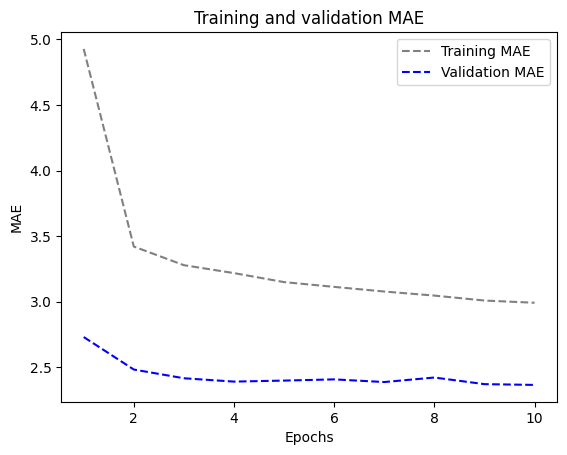

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **3.LSTM - Stacked setup with 16 units**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 273s 322ms/step - loss: 36.0874 - mae: 4.3721 - val_loss: 12.0361 - val_mae: 2.6385
Epoch 2/10
819/819 [==============================] - 258s 314ms/step - loss: 10.1258 - mae: 2.4821 - val_loss: 10.3533 - val_mae: 2.5088
Epoch 3/10
819/819 [==============================] - 217s 265ms/step - loss: 8.7347 - mae: 2.3068 - val_loss: 10.0609 - val_mae: 2.4761
Epoch 4/10
819/819 [==============================] - 218s 266ms/step - loss: 8.0415 - mae: 2.2176 - val_loss: 10.1744 - val_mae: 2.4926
Epoch 5/10
819/819 [==============================] - 260s 317ms/step - loss: 7.5388 - mae: 2.1430 - val_loss: 10.7753 - val_mae: 2.5726
Epoch 6/10
819/819 [==============================] - 217s 265ms/step - loss: 7.0882 - mae: 2.0795 - val_loss: 10.8448 - val_mae: 2.5709
Epoch 7/10
819/819 [==============================] - 218s 266ms/step - loss: 6.6688 - mae: 2.0134 - val_loss: 10.8439 - val_mae: 2.5812
Epoch 8/10
819/819 [===================

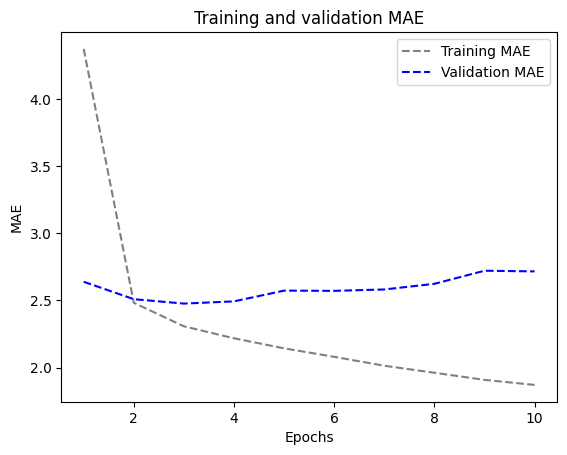

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **4.LSTM - Stacked setup with 32 units**

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 317s 376ms/step - loss: 20.8633 - mae: 3.2796 - val_loss: 9.8738 - val_mae: 2.4451
Epoch 2/10
819/819 [==============================] - 337s 411ms/step - loss: 8.1286 - mae: 2.2160 - val_loss: 10.6552 - val_mae: 2.5547
Epoch 3/10
819/819 [==============================] - 335s 409ms/step - loss: 6.6106 - mae: 1.9964 - val_loss: 10.9819 - val_mae: 2.5789
Epoch 4/10
819/819 [==============================] - 334s 408ms/step - loss: 5.6017 - mae: 1.8302 - val_loss: 11.4753 - val_mae: 2.6419
Epoch 5/10
819/819 [==============================] - 334s 408ms/step - loss: 4.8666 - mae: 1.7038 - val_loss: 12.1240 - val_mae: 2.7225
Epoch 6/10
819/819 [==============================] - 313s 382ms/step - loss: 4.4056 - mae: 1.6175 - val_loss: 12.2606 - val_mae: 2.7371
Epoch 7/10
819/819 [==============================] - 335s 409ms/step - loss: 3.9579 - mae: 1.5320 - val_loss: 12.3157 - val_mae: 2.7345
Epoch 8/10
819/819 [=====================

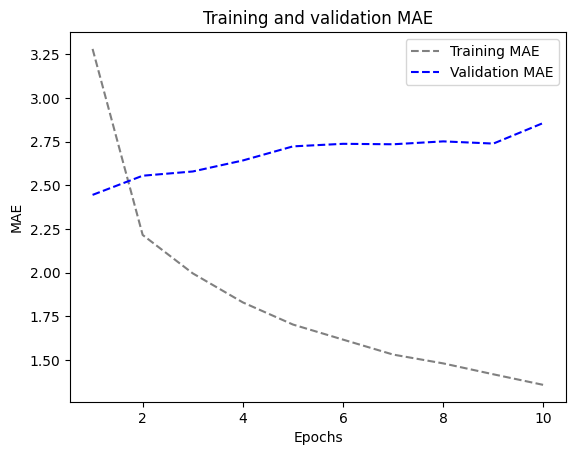

In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **5.LSTM - Stacked setup with 8 units**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 197s 235ms/step - loss: 67.9970 - mae: 6.2833 - val_loss: 33.2689 - val_mae: 4.2592
Epoch 2/10
819/819 [==============================] - 189s 231ms/step - loss: 20.3320 - mae: 3.3381 - val_loss: 12.7176 - val_mae: 2.6953
Epoch 3/10
819/819 [==============================] - 188s 230ms/step - loss: 11.1049 - mae: 2.5809 - val_loss: 9.6947 - val_mae: 2.4058
Epoch 4/10
819/819 [==============================] - 189s 230ms/step - loss: 9.9952 - mae: 2.4682 - val_loss: 9.3569 - val_mae: 2.3701
Epoch 5/10
819/819 [==============================] - 184s 225ms/step - loss: 9.7076 - mae: 2.4320 - val_loss: 9.2135 - val_mae: 2.3430
Epoch 6/10
819/819 [==============================] - 190s 232ms/step - loss: 9.5343 - mae: 2.4096 - val_loss: 9.0717 - val_mae: 2.3221
Epoch 7/10
819/819 [==============================] - 182s 221ms/step - loss: 9.3864 - mae: 2.3892 - val_loss: 9.3738 - val_mae: 2.3658
Epoch 8/10
819/819 [=======================

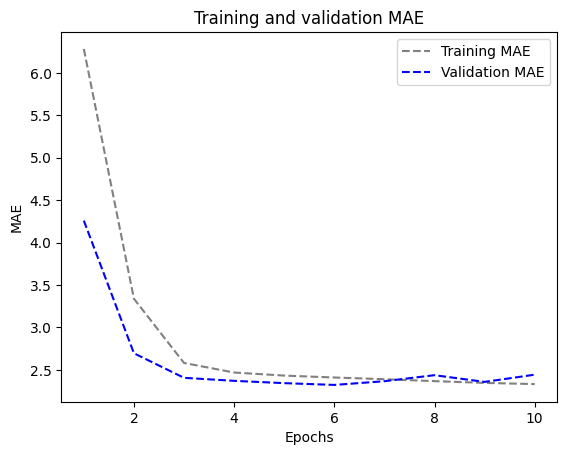

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **6.LSTM - dropout-regularized, stacked model**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 339s 401ms/step - loss: 68.3497 - mae: 6.3318 - val_loss: 31.9592 - val_mae: 4.1894
Epoch 2/10
819/819 [==============================] - 328s 400ms/step - loss: 30.7339 - mae: 4.1587 - val_loss: 13.7660 - val_mae: 2.7925
Epoch 3/10
819/819 [==============================] - 335s 408ms/step - loss: 24.3589 - mae: 3.7376 - val_loss: 11.4791 - val_mae: 2.6121
Epoch 4/10
819/819 [==============================] - 325s 396ms/step - loss: 22.5122 - mae: 3.6008 - val_loss: 10.1713 - val_mae: 2.4624
Epoch 5/10
819/819 [==============================] - 326s 397ms/step - loss: 21.0439 - mae: 3.4853 - val_loss: 10.1551 - val_mae: 2.4668
Epoch 6/10
819/819 [==============================] - 326s 398ms/step - loss: 20.0728 - mae: 3.4028 - val_loss: 9.6235 - val_mae: 2.4028
Epoch 7/10
819/819 [==============================] - 323s 394ms/step - loss: 19.2507 - mae: 3.3356 - val_loss: 9.4450 - val_mae: 2.3810
Epoch 8/10
819/819 [================

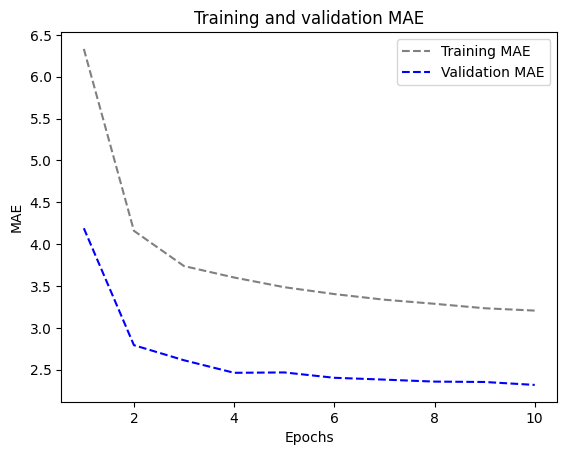

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **Bidirectional LSTM**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 206s 244ms/step - loss: 26.7064 - mae: 3.7280 - val_loss: 10.4961 - val_mae: 2.5140
Epoch 2/10
819/819 [==============================] - 211s 257ms/step - loss: 9.7866 - mae: 2.4416 - val_loss: 9.4474 - val_mae: 2.3821
Epoch 3/10
819/819 [==============================] - 196s 239ms/step - loss: 8.8200 - mae: 2.3136 - val_loss: 9.4990 - val_mae: 2.3871
Epoch 4/10
819/819 [==============================] - 197s 240ms/step - loss: 8.2729 - mae: 2.2402 - val_loss: 9.8886 - val_mae: 2.4241
Epoch 5/10
819/819 [==============================] - 214s 261ms/step - loss: 7.8457 - mae: 2.1814 - val_loss: 9.7079 - val_mae: 2.4019
Epoch 6/10
819/819 [==============================] - 209s 255ms/step - loss: 7.5197 - mae: 2.1350 - val_loss: 10.5387 - val_mae: 2.4857
Epoch 7/10
819/819 [==============================] - 212s 258ms/step - loss: 7.2618 - mae: 2.0986 - val_loss: 10.1030 - val_mae: 2.4504
Epoch 8/10
819/819 [========================

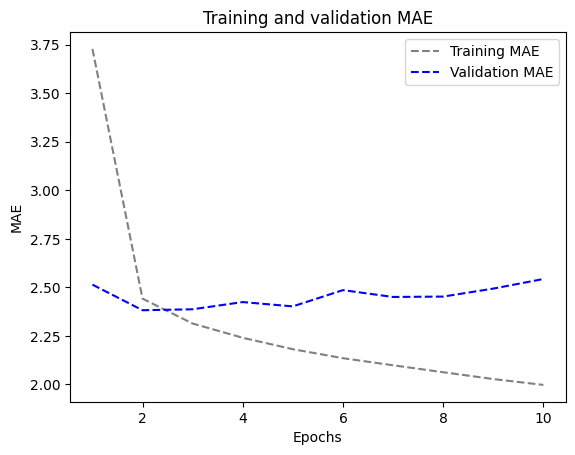

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **1D Convnets and LSTM togther**

In [39]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 165s 195ms/step - loss: 48.2337 - mae: 5.1927 - val_loss: 26.0842 - val_mae: 3.9649
Epoch 2/10
819/819 [==============================] - 141s 171ms/step - loss: 17.7556 - mae: 3.2618 - val_loss: 25.9483 - val_mae: 3.9713
Epoch 3/10
819/819 [==============================] - 141s 171ms/step - loss: 14.8568 - mae: 2.9929 - val_loss: 22.8474 - val_mae: 3.7509
Epoch 4/10
819/819 [==============================] - 160s 195ms/step - loss: 13.1981 - mae: 2.8098 - val_loss: 21.4173 - val_mae: 3.6718
Epoch 5/10
819/819 [==============================] - 143s 174ms/step - loss: 11.9447 - mae: 2.6690 - val_loss: 25.1948 - val_mae: 3.9363
Epoch 6/10
819/819 [==============================] - 143s 174ms/step - loss: 10.9985 - mae: 2.5558 - val_loss: 23.9628 - val_mae: 3.8181
Epoch 7/10
819/819 [==============================] - 141s 171ms/step - loss: 10.2358 - mae: 2.4598 - val_loss: 24.6256 - val_mae: 4.0109
Epoch 8/10
819/819 [==============

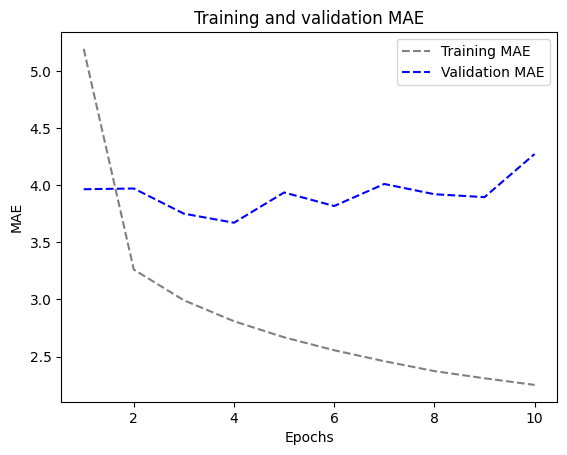

In [40]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Built 14 models: Following are the details;

**Model 1:** common-sense, non-machine-learning baseline

**Model 2:** A basic machine-learning model

**Model 3:** 1D convolutional model

**Model 4:** Simple RNN layer that can process sequences of any length

**Model 5:** Simple RNN - Stacking RNN layers

**Model 6:** A Simple GRU (Gated Recurrent Unit)

**Model 7:** LSTM-Simple

**Model 8:** LSTM - dropout Regularization

**Model 9:** Stacked setup with 16 units

**Model 10:** Stacked setup with 32 units

**Model 11:** Stacked setup with 8 units

**Model 12:** LSTM - dropout-regularized, stacked

**Model 13:** Bidirectional LSTM

**Model 14:** 1D Convnets and LSTM togther

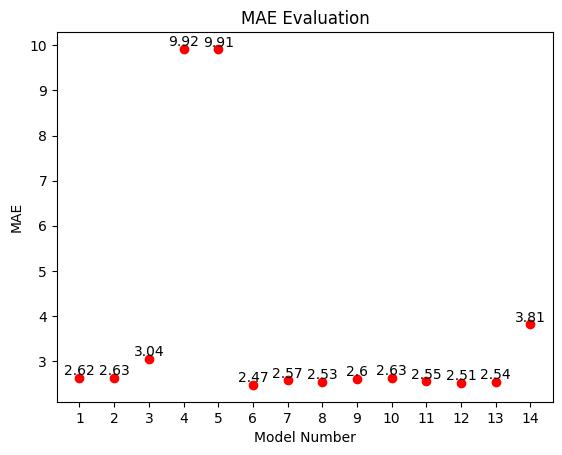

In [41]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.63,3.04,9.92,9.91,2.47,2.57,2.53,2.60,2.63,2.55,2.51,2.54,3.81)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

